# Opponent Cosine Similarities
For each tourney matchup, 
calculate most similar teams to opponent (Team 2) that have played against team 1 in regular season 
calculate the win rate for Team 1 against these similar teams


In [1]:
import pandas as pd
from sklearn import metrics
import numpy as np

from sklearn import preprocessing
our_data_dir = '/Users/hannahparker/march_madness/data/our_data/'
kaggle_data_dir = '/Users/hannahparker/march_madness/data/MDataFiles_Stage1/'

In [2]:
regular_season = pd.read_csv(kaggle_data_dir + 'MRegularSeasonCompactResults.csv')

In [3]:
season_summary = pd.read_csv(our_data_dir + 'season_summary.csv')
season_summary = season_summary.rename(columns={'name':'TeamName',
                       'year':'Season'})

tourney_df = pd.read_csv(our_data_dir + 'tourney_h2h.csv')

In [9]:
cosine_cols = ['adjd',
 'adjemn',
 'adjo',
 'adjt',
 'Ast',
 'Blk',
 'DR',
 'FG3P',
 'FGA',
 'FGA3',
 'FGM',
 'FGM3',
 'FGP',
 'FTA',
 'FTM',
 'FTP',
 'L',
#  'L_tourney',
 'luck',
 'oppds',
 'opponent_Ast',
 'opponent_Blk',
 'opponent_DR',
 'opponent_FG3P',
 'opponent_FGA',
 'opponent_FGA3',
 'opponent_FGM',
 'opponent_FGM3',
 'opponent_FGP',
 'opponent_FTA',
 'opponent_FTM',
 'opponent_FTP',
 'opponent_OR',
 'opponent_PF',
 'opponent_Score',
 'opponent_Stl',
 'opponent_TO',
#  'oppos',
 'OR',
 'PF',
 'Score',
#  'Seed',
#  'Stl',
#  'TO',
#  'W',
#  'W_tourney',
 'WP',
 'WP_5']

In [10]:
# season_summary = season_summary.dropna()

In [11]:
season_summary[cosine_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 41 columns):
adjd              5823 non-null float64
adjemn            5823 non-null float64
adjo              5823 non-null float64
adjt              5823 non-null float64
Ast               5827 non-null float64
Blk               5827 non-null float64
DR                5827 non-null float64
FG3P              5827 non-null float64
FGA               5827 non-null float64
FGA3              5827 non-null float64
FGM               5827 non-null float64
FGM3              5827 non-null float64
FGP               5827 non-null float64
FTA               5827 non-null float64
FTM               5827 non-null float64
FTP               5827 non-null float64
L                 5827 non-null int64
luck              5823 non-null float64
oppds             5823 non-null float64
opponent_Ast      5827 non-null float64
opponent_Blk      5827 non-null float64
opponent_DR       5827 non-null float64
opponent_FG3P  

In [12]:
season_summary.loc[season_summary.TeamID == 1192][cosine_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 1426 to 1442
Data columns (total 41 columns):
adjd              17 non-null float64
adjemn            17 non-null float64
adjo              17 non-null float64
adjt              17 non-null float64
Ast               17 non-null float64
Blk               17 non-null float64
DR                17 non-null float64
FG3P              17 non-null float64
FGA               17 non-null float64
FGA3              17 non-null float64
FGM               17 non-null float64
FGM3              17 non-null float64
FGP               17 non-null float64
FTA               17 non-null float64
FTM               17 non-null float64
FTP               17 non-null float64
L                 17 non-null int64
luck              17 non-null float64
oppds             17 non-null float64
opponent_Ast      17 non-null float64
opponent_Blk      17 non-null float64
opponent_DR       17 non-null float64
opponent_FG3P     17 non-null float64
opponent_FGA      17

In [13]:
n=10

def get_win_rate_similar_opponents(row, team = 'team1', opponent='team2'):
    year = row['Season']
    team = row['{team}_TeamID'.format(team=team)]
#     print(team, row['{opponent}_TeamID'.format(opponent=opponent)], year)
    opponent = row['{opponent}_TeamID'.format(opponent=opponent)]
    reg_season_opponents = regular_season.loc[(regular_season.Season == year)
                                             & ((regular_season.WTeamID == team) |
                                                (regular_season.LTeamID == team))]
    
    reg_season_opponents = reg_season_opponents['WTeamID'].unique().tolist() + reg_season_opponents['LTeamID'].unique().tolist()

    subset = season_summary.loc[(season_summary.Season == year)
                           & (season_summary.TeamID.isin(reg_season_opponents + [opponent]))][['TeamID'] + cosine_cols].dropna()
    X = subset[cosine_cols]
    X = X
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X.values)
    cosinedf = pd.DataFrame(x_scaled)

    cosine_sims = pd.DataFrame(metrics.pairwise.cosine_similarity(cosinedf, Y=None, dense_output=True))

    cosine_sims.columns = subset.TeamID.tolist()
    cosine_sims['Team'] = subset.TeamID.values
    cosine_sims = cosine_sims.loc[cosine_sims[opponent] >= .8]
    top_n = cosine_sims[['Team',opponent]].sort_values(by=opponent,ascending=False)[0:n]
    top_n.columns= ['Similar Team','Cosine']
    top_n['Team'] = opponent
    similar_teams = top_n['Similar Team'].unique().tolist()

    n_wins = regular_season.loc[(regular_season.WTeamID == team)
                            & (regular_season.LTeamID.isin(similar_teams))
                            & (regular_season.Season == year)]
    
    n_losses = regular_season.loc[(regular_season.LTeamID == team)
                            & (regular_season.WTeamID.isin(similar_teams))
                            & (regular_season.Season == year)]

    try:
        row['pct_wins_similar'] = n_wins.shape[0] / (n_wins.shape[0] + n_losses.shape[0])
        row['n_wins'] = n_wins.shape[0]
    except Exception as e:
        row['pct_wins_similar'] = np.nan
        row['n_wins'] = 0
    return row[['pct_wins_similar','n_wins']]




In [14]:
tourney_df[['team1_pct_wins_similar','team1_n_wins_similar']] = tourney_df.apply(lambda row: get_win_rate_similar_opponents(row,
                                                                                                    team = 'team1', 
                                                                                                    opponent='team2'), 
                                                         axis=1)


In [15]:
tourney_df[['team2_pct_wins_similar','team2_n_wins_similar']]  = tourney_df.apply(lambda row: get_win_rate_similar_opponents(row,
                                                                                                    team = 'team2', 
                                                                                                    opponent='team1'), 
                                                             axis=1)


In [16]:
tourney_df['team1_win_rate_dif'] = (tourney_df['team1_pct_wins_similar'] - tourney_df['team1_WP']).astype(float)
tourney_df['team2_win_rate_dif'] = tourney_df['team2_pct_wins_similar'] - tourney_df['team2_WP']

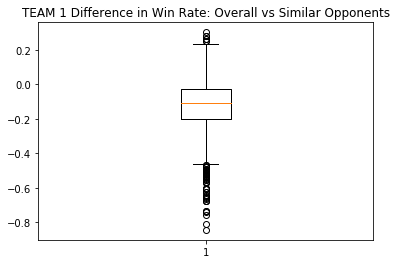

In [28]:
# dif in percentage points between similar team win rate & overall win rate
# (> 0 ) means team is more likely to win against similar opponents

import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.set_title('TEAM 1 Difference in Win Rate: Overall vs Similar Opponents')
ax1.boxplot(tourney_df.loc[tourney_df['team1_win_rate_dif'].notnull()]['team1_win_rate_dif'])
plt.show()

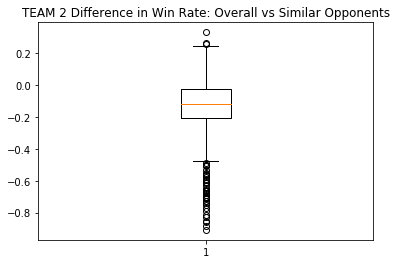

In [29]:
fig1, ax1 = plt.subplots()
ax1.set_title('TEAM 2 Difference in Win Rate: Overall vs Similar Opponents')
ax1.boxplot(tourney_df.loc[tourney_df['team2_win_rate_dif'].notnull()]['team2_win_rate_dif'])
plt.show()

In [30]:
# check out 2019 tourney games for Duke
tourney_df.loc[(tourney_df.Season == 2019) & 
    ((tourney_df.team1_TeamName=='Duke') | (tourney_df.team2_TeamName =='Duke'))][['team1_TeamName',
                                                                                    'team2_TeamName',
                                                                                   'team1_WP',
                                                                                   'team2_WP',
                                                                                    'team1_pct_wins_similar',
                                                                                   'team2_pct_wins_similar',
                                                                                   'team1_n_wins_similar',
                                                                                   'team2_n_wins_similar',
                                                                                  'outcome',
                                                                                  'team1_Seed',
                                                                                  'team2_Seed']]

,team1_TeamName,team2_TeamName,team1_WP,team2_WP,team1_pct_wins_similar,team2_pct_wins_similar,team1_n_wins_similar,team2_n_wins_similar,outcome,team1_Seed,team2_Seed
1055,N Dakota St,Duke,0.516129,0.852941,0.000000,1.000000,0,9,L,16,1
1067,UCF,Duke,0.741935,0.852941,0.636364,0.818182,7,9,L,9,1
1072,Virginia Tech,Duke,0.750000,0.852941,0.545455,0.692308,6,9,L,4,1
1076,Duke,Michigan St,0.852941,0.823529,0.727273,0.583333,8,7,L,1,2


In [20]:
tourney_df.to_csv(our_data_dir + 'tourney_df_w_similar_opponent_scores.csv',index=False)

In [21]:
tourney_df.team1_n_wins_similar.describe()

count    1078.000000
mean        6.845083
std         3.124339
min         0.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        15.000000
Name: team1_n_wins_similar, dtype: float64

In [22]:
tourney_df.team2_n_wins_similar.describe()

count    1078.000000
mean        6.649351
std         3.079186
min         0.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        15.000000
Name: team2_n_wins_similar, dtype: float64

In [23]:
tourney_df['team1_win_rate_dif'].describe()

count    1063.000000
mean       -0.121422
std         0.162512
min        -0.843750
25%        -0.200529
50%        -0.105991
75%        -0.024352
max         0.303030
Name: team1_win_rate_dif, dtype: float64

In [24]:
tourney_df['team2_win_rate_dif'].describe()

count    1067.000000
mean       -0.129497
std         0.168747
min        -0.909091
25%        -0.207071
50%        -0.114583
75%        -0.023841
max         0.333333
Name: team2_win_rate_dif, dtype: float64